**A custom scatter plot function in Python**

I wanted an easy way to plot scatter plots with the following criteria:

 - one feature represented by marker size
 - a feature defining groups represented by marker color
 - both color and size are defined by legends on the plot

Despite much Googling and perusing of StackOverflow, I couldn't find an easy way to do this with matplotlib and seaborn. I tried with the Python version of ggplot but encountered a bug. Therefore, I wrote my own function I called g_scatter where color and size are faithfully represented.

In [69]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from ggplot import *    # requires a pip install
%matplotlib inline

## Create data frame for test cases

Values of the dataframe will make it easy to see if the functions are working properly. Later, I'll try a data frame with a variety of distributions.

In [82]:
# Number of samples (training examples). Use a small m (30) to verify plotting properties and large m (1000) as a test case
m = 30
uniform_dist = np.arange(0, m)
gaussian_dist = np.random.normal(loc=100, scale=20, size=m)

# Create dataframe with numerical features
df = pd.DataFrame({'uniform': uniform_dist,
                  'gaussian': gaussian_dist,
                  })

# Create classification features and add to dataframe
k = 5     # Number of groups
groupSize = round(m/k)
df['class_even'] = (['group 1']*groupSize + ['group 2']*groupSize
                     + ['group 3']*groupSize + ['group 4']*groupSize
                     + ['group 5']*(m-groupSize*(k-1)))

In [81]:
df

,gaussian,uniform,class_even
0,104.899363,0,group 1
1,99.665408,1,group 1
2,102.651727,2,group 1
3,93.015040,3,group 1
4,96.479393,4,group 1
5,95.359002,5,group 1
6,90.057614,6,group 2
7,105.310450,7,group 2
8,84.836361,8,group 2
9,93.802528,9,group 2


## Scatter plots with ggplot

In [63]:
from ggplot import *

/Users/lacar/anaconda/lib/python3.5/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/Users/lacar/anaconda/lib/python3.5/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/Users/lacar/anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


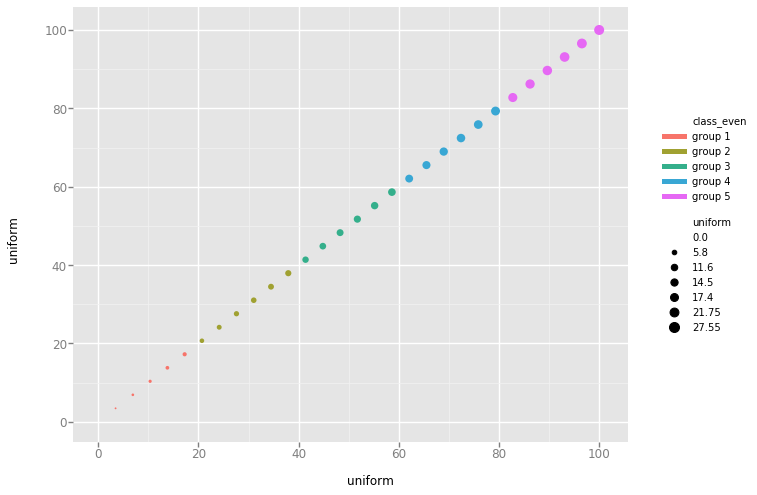

<ggplot: (-9223372036562770979)>

In [72]:
# Plotting with Python ggplot
f, (ax1) = plt.subplots(1,1)
ggplot(df, aes(x='uniform', y='uniform', size='uniform', color='class_even')) + geom_point()

On the surface, this seems like a nice way of creating a scatter plot and fulfilling my <a href="#top">criteria</a>. However, if you take a close look at the plot, the first group in red is only represented by five points while all others have six. In addition, the figure legend is missing that point.

Perhaps it's just an artifact of that value being zero? When I used the "gaussian" set of values in the dataframe (so that all values are positive), the disappearing point comes back but the figure legend still has a missing point.

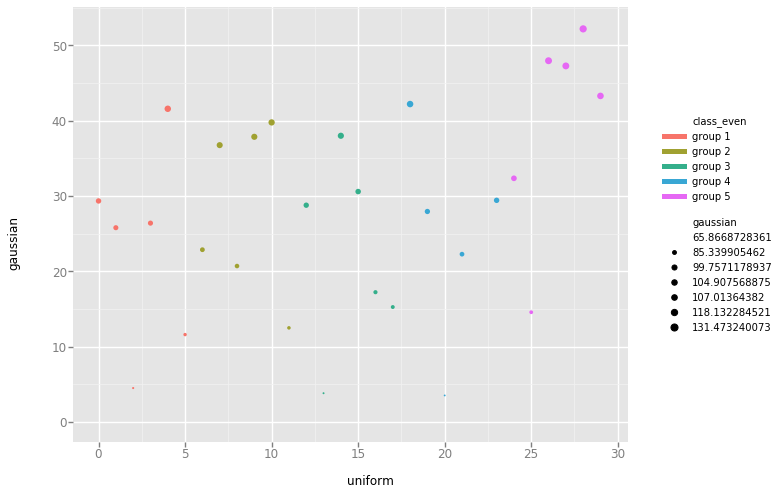

<ggplot: (-9223372036559844534)>

In [84]:
# Plotting with Python ggplot
f, (ax1) = plt.subplots(1,1)
ggplot(df, aes(x='uniform', y='gaussian', size='gaussian', color='class_even')) + geom_point()

## Scatter plots with g_scatter, a custom function based on matplotlib

It took a lot of time piecing together bits I could find from StackOverflow, other blogs, and matplotlib documentation. I regret not documenting every reference and apologize to those for not properly giving credit. Nevertheless, I hope I've commented sufficiently to provide my mindset into this code.

In [85]:
def g_scatter(df, x, y, size, color, ax):
        
    markerSize=df[size]

    # Make a sizes vector and add it to the dataframe (removed at the end of the function)
    szMaxMarker = 200
    df['sizes_gScatter'] = 1+szMaxMarker*((markerSize-markerSize.min())/(markerSize.max()-markerSize.min()))
    

    # Create a plot as an underlayer, serving as a proxy for the legend for marker size
    noLegendPoints = 5  # number of points (default will be 5)

    # legend points, distributed through the size range
    legendPoints_ideal = np.linspace(markerSize.min(),
                                     markerSize.max(),
                                     noLegendPoints)  

    # get dataframe rows that are closest to the legendPoints_ideal
    # dense list comprehension to get the closest values in the dataset that are distributed
    legendPoints_data = [(df[size].iloc[(df[size]-x).abs().argsort().iloc[0]]) for x in legendPoints_ideal]
    
    # find the rows and make a new dataframe; 
    dfTemp = df[df[size].isin(legendPoints_data)]  
    dfTemp2 = dfTemp.sort_values(by='sizes_gScatter')   # sort by size

    # plot this as an underlayer (plotted here, before plotting all data)
    for i, data in dfTemp2.iterrows():
        # while this is an underlayer, set the plot points to white so it's the same as the background
        ax.scatter(data[x], data[y], s=(data['sizes_gScatter']), c='w', label= "%.2f" % data[size])

    # ax.scatter(data[x], data[y], s=markerSize)   #, c='w', label= "%.2f" % data['feature_sz']) #label=str(data['feature_sz']))

    # --- Place the legend which should only show for the underlaying plot ---
    first_legend = ax.legend(title=size, loc='upper left', bbox_to_anchor=(1,1))
    # Manually set the colors of the marker legends to black (the legend points would have been white or non-visible)
    for i in range(len(first_legend.legendHandles)):
         first_legend.legendHandles[i].set_color('black')

    # Add first legend manually to the current Axes.
    plt.gca().add_artist(first_legend)        

    # colors for categorical variables  
    #colors=['gray', 'blue', 'green', 'yellow', 'red']

    # ax.scatter(df['feature_x'], df['feature_y'], s=df['sizes'], color='k', label=None) #, color='k', 

    for i,data in enumerate(df[color].unique()):
        dfTemp = df[df[color]==data]
        ax.scatter(x=dfTemp[x], y=dfTemp[y], s=dfTemp['sizes_gScatter'], c=colors[i], label=None)

    # re-plotting for the purposes of the class legend

    # Using mpatches to add second legend with colors of the groups 
    import matplotlib.patches as mpatches
    groups = df[color].unique().tolist()
    group_patches = list()
    for i,data in enumerate(groups):
        #print(i, data, groups[i])
        group_patches.append(mpatches.Patch(color=colors[i], label=data))

    # changed the handlelength parameter to 0.7 to get square-shaped colored boxes in the legend    
    ax.legend(handles=group_patches, title='group', loc='upper left', bbox_to_anchor=(1,0.5), handlelength=0.7)

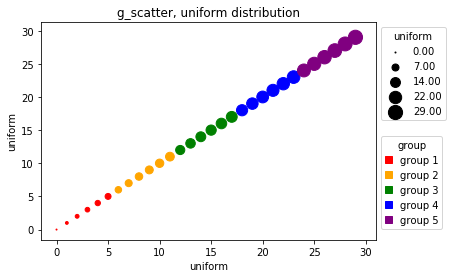

In [86]:
# Plotting with g_scatter function
colors = ['red', 'orange', 'green', 'blue', 'purple']

f, ax1 = plt.subplots(1,1);
g_scatter(df=df, x='uniform', y='uniform', size='uniform', color='class_even', ax=ax1);
ax1.set_title('g_scatter, uniform distribution');
ax1.set_xlabel('uniform');
ax1.set_ylabel('uniform');

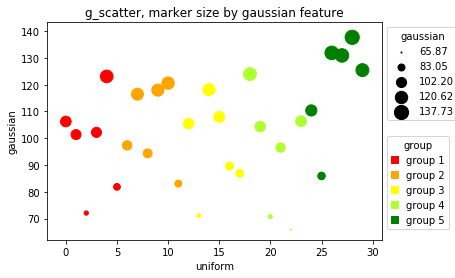

In [88]:
# Plotting with g_scatter function

colors = ['red', 'orange', 'yellow', 'greenyellow', 'green', 'cyan', 'blue', 'magenta', 'purple', 'black']

f, ax1 = plt.subplots(1,1);
g_scatter(df=df, x='uniform', y='gaussian', size='gaussian', color='class_even', ax=ax1);
ax1.set_title('g_scatter, marker size by gaussian feature');
ax1.set_xlabel('uniform');
ax1.set_ylabel('gaussian');

Here you can see that in both plots, all groups have six points and the legend represents both sizes and colors as desired.

I wrote more about why I worked on this [here](https://benslack19.github.io/data%20science/gscatter/). The code for the g_scatter function can be used above or obtained fom my Github page [here](https://github.com/benslack19/g_scatter).